In [ ]:
'''Import basic libraries and mount the google drive'''
import os
import threading
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('./gdrive/My Drive/ML/Project')

In [0]:
'''Import libraries and store the names of images in data folder'''
import libs.image_utils as iu
import numpy as np
import cv2

path = './Data/'
names_exist = list()
files = os.listdir(path)
for file in files:
    if file.endswith(".jpg"):
        names_exist.append(file.strip('.jpg'))

'Copy of util.py'   image_utils.py   __pycache__   srgan.py   util.py


In [0]:
'''Use this cell to delete empty files in the data folder'''
im1 = cv2.imread(path + 'n00005787_346.jpg')
for file in names_exist:
    im2 = cv2.imread(path + file+'.jpg')
    if np.array_equal(im1,im2):
        print(file)
        os.remove(os.path.join(path, file+'.jpg'))
print('done')

In [0]:
'''Use this cell to download images from said url by  using multi-threading(100 threads) at a time'''
urls,names = iu.get_names_url(2)
for i in range(len(urls)):
  #print('name: ',names[i]) #print('url: ',urls[i])
    if threading.active_count() <= 100:
        if names[i] not in names_exist:
            img_path = path + str(names[i])+'.jpg'
            threading.Thread(target=iu.download_img, args=(urls[i],img_path)).start()
            names_exist.append(names[i])
            wait = True
    else:
        while(wait):
            if threading.active_count() <= 100:
            wait = False
            i= i-1
        
print("Done!")

In [ ]:
'''Use this cell to import libraries for training'''
!pip install imageio
import imageio
import numpy as np

from skimage.transform import resize
import matplotlib.pyplot as plt

from libs.srgan import SRGAN
from libs.util import plot_test_images

In [ ]:
'''This cell trains srgan using learning rate 10^(-4)'''
gan = SRGAN(gen_lr=1e-4, dis_lr=1e-4, gan_lr=1e-4)
gan.load_weights('./weights/imagenet_generator.h5', './weights/imagenet_discriminator.h5')
gan.train(
    epochs=10100,
    dataname='imagenet',
    datapath='./Data/',
    batch_size=1,
    test_images=[
        './Baboon.jpg'
    ],
    test_frequency=5000,
    test_path='./images/',
    weight_path='./weights/',
    weight_frequency=100,
    print_frequency=100
)  

In [ ]:
'''This cell trains srgan using learning rate 10^(-5)'''
gan = SRGAN(gen_lr=1e-5, dis_lr=1e-5, gan_lr=1e-5)
gan.load_weights('./weights/imagenet_generator.h5', './weights/imagenet_discriminator.h5')
gan.train(
    epochs=20100,
    dataname='imagenet',
    datapath='./Data/',
    batch_size=1,
    test_images=[
        './Baboon.jpg'
    ],
    test_frequency=5000,
    test_path='./images/',
    weight_path='./weights/',
    weight_frequency=100,
    print_frequency=100
) 

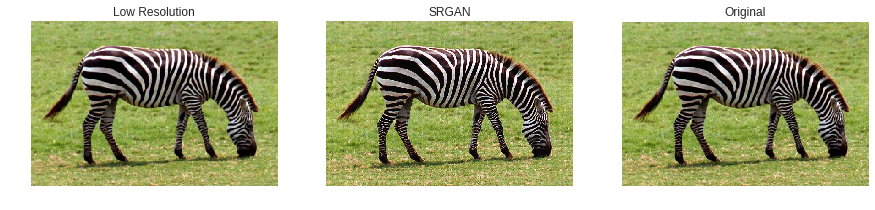

In [0]:
'''This cell is used to test the trained srgan'''
gan = SRGAN(gen_lr=1e-5, dis_lr=1e-5, gan_lr=1e-5)
gan.load_weights('./weights/imagenet_generator.h5', './weights/imagenet_discriminator.h5')
img_hr = imageio.imread("./zebra.png").astype(np.float) / 127.5 - 1 

# Create a low-resolution version of it
lr_shape = (int(img_hr.shape[0]/2), int(img_hr.shape[1]/2))
img_lr = resize(img_hr, lr_shape, mode='constant')

# Predict high-resolution version (add batch dimension to image)
img_sr = gan.generator.predict(np.expand_dims(img_lr, 0))

# Remove batch dimension
img_sr = np.squeeze(img_sr, axis=0)

# Images and titles
images = {
    'Low Resolution': img_lr, 'SRGAN': img_sr, 'Original': img_hr
}

path = './test/'
imageio.imwrite(path+'zebra_2_img_lr.jpg',img_lr)
imageio.imwrite(path+'zebra_2_img_sr.jpg',img_sr)
imageio.imwrite(path+'zebra_2_img_hr.jpg',img_hr)
# Plot the images. Note: rescaling and using squeeze since we are getting batches of size 1                    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (title, img) in enumerate(images.items()):
    axes[i].imshow(0.5 * img + 0.5)
    axes[i].set_title(title)
    axes[i].axis('off')
plt.show()